<h2>Sentiment Analysis using LSTM</h2>

<p>This notebook presents a deep learning approach to binary sentiment classification of text data using a stacked LSTM model with pretrained word embeddings.</p>

<h3>Project Structure</h3>
<ol>
  <li><b>Data Preprocessing:</b> Tokenization, padding, and conversion to sequences using GloVe embeddings.</li>
  <li><b>Model Building:</b> LSTM-based neural network with dropout and sigmoid output.</li>
  <li><b>Training:</b> Model trained with class weights and early stopping for stability.</li>
  <li><b>Evaluation:</b> Performance visualized using accuracy/loss curves and a normalized confusion matrix.</li>
  <li><b>Error Analysis:</b> Display of misclassified examples to understand model weaknesses.</li>
</ol>

<p><i>Goal:</i> Build a robust classifier that effectively distinguishes between positive and negative sentiments in text reviews.</p>


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, F1Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import L2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from Pre_Trained_Embedding import *
palette = sns.color_palette('Set2')

<h3>Summary: Data Loading & Sentiment Labeling</h3>

<ul>
  <li>Loaded Amazon reviews dataset using <code>pandas</code>.</li>
  <li>Removed missing values to clean the data.</li>
  <li>Mapped review ratings to sentiment classes:
    <ul>
      <li><strong>Positive</strong> → 1</li>
      <li><strong>Neutral</strong> & <strong>Negative</strong> → 0</li>
    </ul>
  </li>
  <li>Created a new <code>Sentiment</code> column for model training.</li>
</ul>


In [89]:
df = pd.read_csv("Amazon Review Data Web Scrapping.csv")

In [90]:
df.head(10)

,Unique_ID,Category,Review_Header,Review_text,Rating,Own_Rating
0,136040,smartTv,Nice one,I liked it,5,Positive
1,134236,mobile,Huge battery life with amazing display,I bought the phone on Amazon and been using my...,5,Positive
2,113945,books,Four Stars,"Awesome book at reasonable price, must buy ......",4,Positive
3,168076,smartTv,Nice quality,good,5,Positive
4,157302,books,Nice book,"The book is fine,not bad,contains nice concept...",3,Neutral
5,146539,smartTv,Nice tv,Nice tv and pic quality .good custmer srrvice ...,5,Positive
6,157661,smartTv,Beauty and the Beast,The iPhone 7 is legitimately among the most in...,5,Positive
7,110329,mobile,"20000 mAH, what more you need","20000 mAH, what more you need. Super product",5,Positive
8,157473,mobile,Need more good quality,The company should give more Bettany backup an...,2,Negative
9,163223,mobile accessories,Good phone,Very good phone,5,Positive


In [91]:
df.count()

Unique_ID        60889
Category         60889
Review_Header    60884
Review_text      60857
Rating           60889
Own_Rating       60889
dtype: int64

In [92]:
df.dropna(inplace = True)

In [93]:
df.count()

Unique_ID        60855
Category         60855
Review_Header    60855
Review_text      60855
Rating           60855
Own_Rating       60855
dtype: int64

In [94]:
total_review = df.count(0).mean()

In [95]:
sentiment = ['Positive', 'Negative']
sentiment_class = {'Positive':1, 'Neutral':0, 'Negative' : 0}

In [96]:
df['Sentiment'] = df.Own_Rating.apply(lambda x: sentiment_class[x])

<h3>Summary: Sentiment Stats & Visualization</h3>

<ul>
  <li>Calculated normalized sentiment counts and log bias for model initialization.</li>
  <li>Computed class weights to handle class imbalance during training.</li>
  <li>Visualized review distribution by rating using bar charts.</li>
  <li>Analyzed rating distribution across product categories.</li>
  <li>Added <code>Wordcount</code> and <code>Words</code> columns to analyze review text length and content.</li>
</ul>


In [97]:
Sentiment_count = df.groupby('Sentiment').Unique_ID.count().reset_index()
Sentiment_count.Unique_ID = Sentiment_count.Unique_ID / total_review
Sent_count = np.array(Sentiment_count.Unique_ID)
Sentiment_bias = np.log(np.array(Sentiment_count.Unique_ID[1]))
bias_init = Constant(Sentiment_bias)

class_weights = 1 / (2 * Sent_count)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weight_dict)

{0: 2.262435868837832, 1: 0.6418491330211366}


In [98]:
Sentiment_bias

-0.24974518235786894

In [99]:
rating_count = df.groupby('Rating').Unique_ID.count().reset_index()
print(rating_count)

   Rating  Unique_ID
0       1       6979
1       2       2107
2       3       4363
3       4      12968
4       5      34438


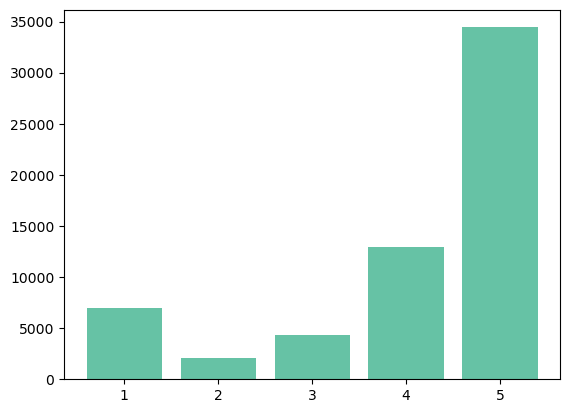

In [100]:
plt.bar(rating_count.Rating , rating_count.Unique_ID , color = palette[0])
plt.show()

In [101]:
rating_category_count = df.pivot_table(
    values="Unique_ID",
	index="Category",
	columns="Rating",
	aggfunc= 'count'
)
print(rating_category_count)

Rating                 1    2     3     4      5
Category                                        
books                143   64   189   674   2838
mobile              2663  831  1735  4864  12647
mobile accessories  1858  578  1231  3490   7653
refrigerator         465  121   273   998   2927
smartTv             1850  513   935  2942   8373


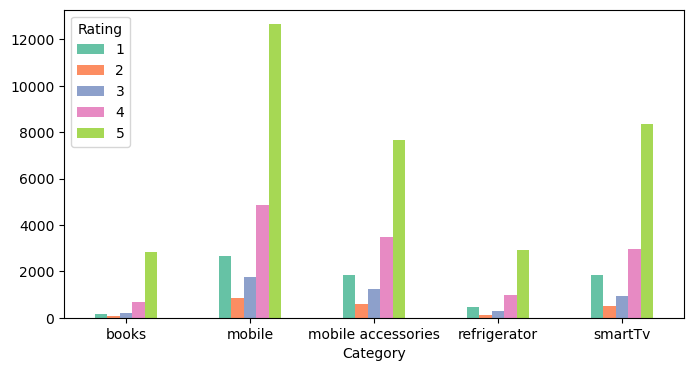

In [102]:
fig , ax = plt.subplots(figsize=(8, 4))
rating_category_count.plot(kind = 'bar', stacked = False,color = palette, ax = ax)
plt.xticks(rotation = 0)
plt.show()

In [103]:
df['Wordcount'] = df.Review_text.apply(lambda x: len(x.split(' ')))
df['Words'] = df.Review_text.apply(lambda x: x.split(' '))

<h3>Summary: Text Length Analysis & Data Preparation</h3>

<ul>
  <li>Plotted two histograms to visualize the distribution of word counts in review texts using different bin sizes.</li>
  <li>Annotated histograms with the percentage of total reviews falling in each bin.</li>
  <li>Filtered dataset to keep only reviews with less than 32 words for model input.</li>
  <li>Loaded pre-trained GloVe embeddings to create word-to-index and word-to-vector mappings.</li>
  <li>Converted cleaned review texts into index-based format for neural network input.</li>
  <li>Split data into training, validation, and test sets for model training.</li>
</ul>


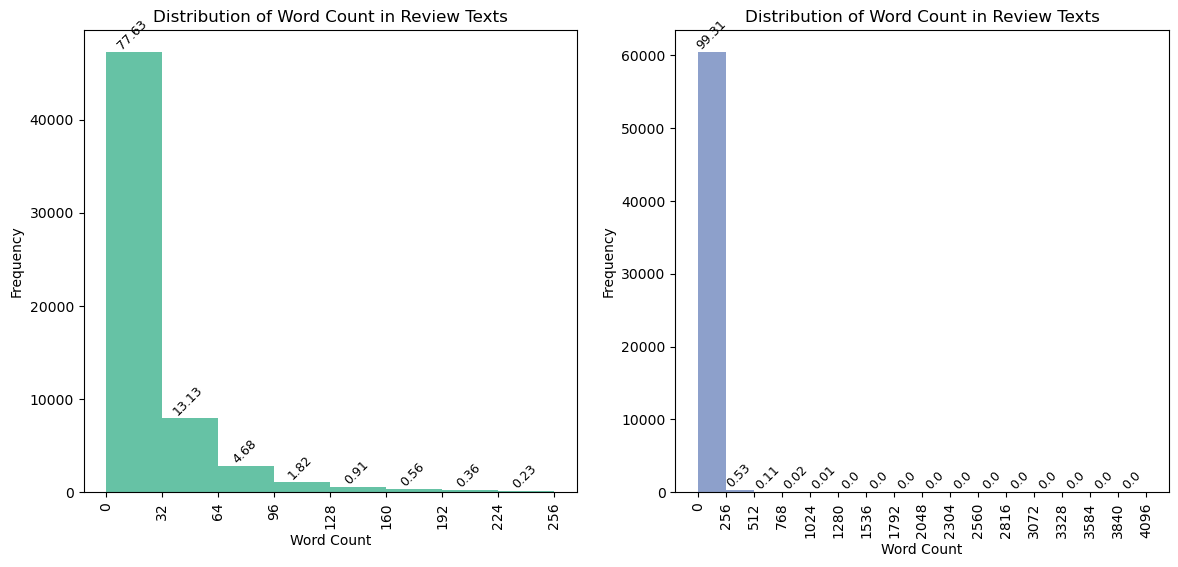

In [104]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
bins_np = np.arange(0,288,32)
counts, bins, patches = plt.hist(df.Wordcount, bins = bins_np, color = palette[0])
plt.xticks(bins_np,rotation = 90)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in Review Texts')
for count, bin_left in zip(counts, bins[:-1]):
    plt.text(bin_left + 15, count + 1, str(round(100*count/total_review,2)), ha='center', va='bottom', fontsize=9,rotation = 45)


plt.subplot(1,2,2)
bins_np2 = np.arange(0,4352,256)
counts2, bins2, patches2 = plt.hist(df.Wordcount, bins = bins_np2, color = palette[2])
plt.xticks(bins_np2,rotation = 90)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in Review Texts')
for count, bin_left in zip(counts2, bins2[:-1]):
    plt.text(bin_left + 120, count + 1, str(round(100*count/total_review,2)), ha='center', va='bottom', fontsize=9,rotation = 45)
plt.show()

In [105]:
max_len = 32

In [106]:
df_updated = df[df.Wordcount < max_len]

In [107]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [1]:
X = np.array(df_updated.Review_text)
Y = np.array(df_updated.Sentiment)

X_ind = sentences_to_indices(X, word_to_index, max_len)
embedding_layer = pretrained_embedding_layer(word_to_index,word_to_vec_map)

xtrain, x_test, ytrain, y_test = train_test_split(X_ind, Y, train_size = 0.9, shuffle = True)
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, train_size = 0.8, shuffle = True)

NameError: name 'np' is not defined

In [ ]:
X = np.array(df_updated.Review_text)

In [109]:
Y = np.array(df_updated.Sentiment)

In [110]:
X_ind = sentences_to_indices(X, word_to_index, max_len)

In [111]:
embedding_layer = pretrained_embedding_layer(word_to_index,word_to_vec_map)

In [112]:
xtrain, x_test, ytrain, y_test = train_test_split(X_ind, Y, train_size = 0.9, shuffle = True)

In [113]:
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, train_size = 0.8, shuffle = True)

In [114]:
X_ind.shape, x_train.shape, x_val.shape, x_test.shape

((47239, 32), (34012, 32), (8503, 32), (4724, 32))

In [115]:
Y.shape, y_train.shape, y_val.shape, y_test.shape

((47239,), (34012,), (8503,), (4724,))

<h3>Summary: LSTM Model for Sentiment Classification</h3>

<ul>
  <li>Defined a 3-layer LSTM neural network with dropout for regularization.</li>
  <li>Used pre-trained word embeddings as input to the model.</li>
  <li>Final output layer is a sigmoid-activated dense layer for binary sentiment classification.</li>
  <li>Compiled the model using Adam optimizer and binary cross-entropy loss.</li>
  <li>Trained the model with:
    <ul>
      <li>Early stopping to prevent overfitting</li>
      <li>Class weights to address data imbalance</li>
      <li>Validation split for model performance monitoring</li>
    </ul>
  </li>
  <li>Saved initial model weights and continued training from the last epoch with early stopping.</li>
</ul>

In [168]:
def sentiment_model(max_len):
    sentance_input = Input(shape = (max_len,))

    embeddings = embedding_layer(sentance_input)

    X = LSTM(units = 256, return_sequences=True)(embeddings)
    X = Dropout(rate = 0.2)(X)
    X = LSTM(units = 64, return_sequences=True)(X)
    X = Dropout(rate = 0.2)(X)
    X = LSTM(units = 16, return_sequences=False)(X)
    outputs = Dense(units = 1, activation = 'sigmoid', bias_initializer = bias_init)(X)

    model = Model(sentance_input, outputs)

    model.compile(optimizer = Adam(learning_rate=0.001,), loss = BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])
    return model

In [169]:
sentiment_prediction_model = sentiment_model(max_len)

In [170]:
ES = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [171]:
sentiment_prediction_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 32, 50)              │      20,000,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 32, 256)             │         314,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 32, 64)              │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,401,795 (77.83 MB)

 Trainable params: 401,745 (1.53 MB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [172]:
history = sentiment_prediction_model.fit(x_train, y_train,
                               validation_data = (x_val,y_val),
                               batch_size = 2048,
                               epochs = 20,class_weight = class_weight_dict)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4692 - loss: 0.6330 - val_accuracy: 0.7758 - val_loss: 0.4708
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7674 - loss: 0.4829 - val_accuracy: 0.7677 - val_loss: 0.5002
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7898 - loss: 0.4584 - val_accuracy: 0.7828 - val_loss: 0.4820
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7966 - loss: 0.4460 - val_accuracy: 0.7975 - val_loss: 0.4369
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8026 - loss: 0.4386 - val_accuracy: 0.7992 - val_loss: 0.4395
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8134 - loss: 0.4253 - val_accuracy: 0.8103 - val_loss: 0.4054
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8196 - loss: 0.4103 - val_accuracy: 0.8358 - val_loss: 0.3770
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8223 - loss: 0.4140 - val_accuracy: 0.8331 - val_loss:

In [220]:
weights_init = sentiment_prediction_model.get_weights()

In [221]:
history_cont = sentiment_prediction_model.fit(x_train, y_train,
                                              validation_data = (x_val,y_val),
                                              batch_size = 2048,epochs = 50,
                                              class_weight = class_weight_dict,
                                              initial_epoch=history.epoch[-1],
                                              callbacks = [ES])

Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8677 - loss: 0.3441 - val_accuracy: 0.8512 - val_loss: 0.3775
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8732 - loss: 0.3416 - val_accuracy: 0.8682 - val_loss: 0.3199
Epoch 22/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8560 - loss: 0.3672 - val_accuracy: 0.8572 - val_loss: 0.3689
Epoch 23/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8759 - loss: 0.3344 - val_accuracy: 0.8664 - val_loss: 0.3278
Epoch 24/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8708 - loss: 0.3378 - val_accuracy: 0.8541 - val_loss: 0.3505
Epoch 25/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8752 - loss: 0.3263 - val_accuracy: 0.8385 - val_loss: 0.3812
Epoch 26/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8720 - loss: 0.3303 - val_accuracy: 0.8354 - val_loss: 0.3943


<h2>Sentiment Analysis Summary</h2>

<ul>
  <li><b>Model:</b> 3-layer LSTM with GloVe embeddings, dropout regularization, and sigmoid output for binary classification.</li>
  <li><b>Training:</b> Early stopping used over two phases (20 + 30 epochs) with class weights to address imbalance.</li>
  <li><b>Performance:</b>
    <ul>
      <li>Training & validation accuracy ~86%</li>
      <li>Confusion Matrix:
        <ul>
          <li>True Positives: 91%</li>
          <li>True Negatives: 72%</li>
        </ul>
      </li>
    </ul>
  </li>
  <li><b>Insights:</b> Model performs well on positive sentiment but misclassifies 28% of negative reviews.</li>
  <li><b>Next Steps:</b> Improve negative sentiment classification, possibly with more data or advanced models.</li>
</ul>


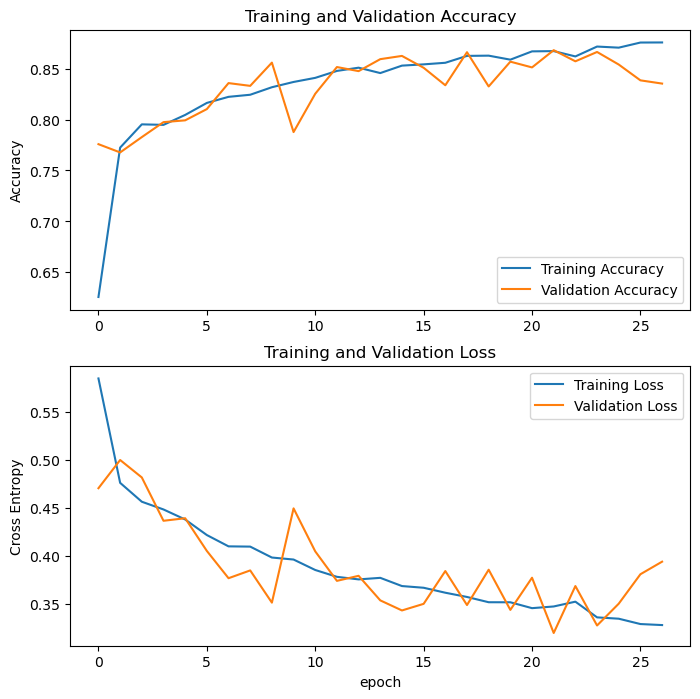

In [222]:
acc = history.history['accuracy'] + history_cont.history['accuracy']
val_acc = history.history['val_accuracy'] + history_cont.history['val_accuracy']

loss = history.history['loss'] + history_cont.history['loss']
val_loss = history.history['val_loss'] + history_cont.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [223]:
y_pred = sentiment_prediction_model.predict(x_test)

148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [224]:
y_pred = y_pred.reshape(y_test.shape)

In [225]:
y_hat = (y_pred > 0.5).astype(int)

In [226]:
misclass_idx = (y_test != y_hat)
pos_idx = (y_test == 1)
misclass_pos_idx = misclass_idx * pos_idx
neg_idx = (y_test == 0)
misclass_neg_idx = misclass_idx * neg_idx

In [218]:
print('Nagetive sentiment classified positive \n\n',indices_to_sentences(x_test[misclass_neg_idx], index_to_word)[:10],
      '\n\nPositive sentiment classified nagetive \n\n',indices_to_sentences(x_test[misclass_pos_idx], index_to_word)[:10])

Nagetive sentiment classified positive 

 ['a 1 quality', '', 'the only issue i found in the phone is heat a lot', 'good product i already used other jbl good', 'samsung always gives a quality in this smartphone screen quality is also 15w fast charger in this price', 'i like send tax invoice to my registered mail ok', 'good', 'it charge my phone very i buy 2018 modal of mi power bank that was very good and charge my phone faster than 2019 model of mi power', 'poor take back item my phone is louder than this looks good in shape rest useless for the', 'a decent overrated good for'] 

Positive sentiment classified nagetive 

 ['had battery expect this from one being a one plus user from has disappointed me with battery backup n sometimes even the phone gets hanged', 'really but when i logged into the play store then after all updates it will be', 'i like when purchase but prise so suddenly down its really i was purchased but now price only thousand', 'undoubtedly class apart', 'picture qu

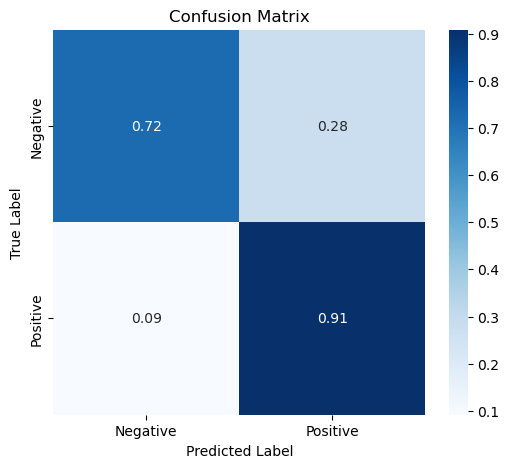

In [227]:
cm = confusion_matrix(y_test, y_hat)
cmsum = cm.sum(axis = 1)
cm2 = np.zeros((2,2))
for i in range(2):
    cm2[i,:] = cm[i,:] / cmsum[i]


plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt="0.2f", cmap="Blues", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
